In [120]:
cd /private/home/ccaucheteux/hasson-syntaxe-vs-semantics/

/private/home/ccaucheteux/hasson-syntaxe-vs-semantics


In [121]:
from structural_probes import probe

In [166]:
from src import paths
import pandas as pd
import torch
from pathlib import Path

EXP_NAME = "0323_wiki_500_seeds_200_valid_mean"

df = pd.read_csv(paths.data / "wiki_bar_embeddings" / EXP_NAME / "embeddings_paths.csv")
df["is_file"] = df.bar_save_file.apply(lambda x: Path(x).is_file())
df = df.query("model_name=='ptpb-bert-large-cased'")[:5]

In [167]:
df

,Unnamed: 0,input_file,model_name,bar_save_file,base_save_file,tok_save_file,is_file
0,0,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,ptpb-bert-large-cased,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,True
1,1,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,ptpb-bert-large-cased,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,True
2,2,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,ptpb-bert-large-cased,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,True
3,3,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,ptpb-bert-large-cased,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,True
4,4,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,ptpb-bert-large-cased,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,/private/home/ccaucheteux/hasson-syntaxe-vs-se...,True


In [168]:
import numpy as np
import torch
from structural_probes import probe
import structural_probes
from transformers import AutoTokenizer

In [169]:
a

In [170]:
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
from wordfreq import zipf_frequency

def get_bar_emb(df, n, concat=True, feat="bar_save_file"):
    bar = []
    i = 0
    for i, row in df.iterrows():
        tmp = torch.load(row[feat])
        for sent in tqdm(tmp):
            i+=1
            bar.append(sent[:, :n].mean(1))
    if concat:
        bar = torch.cat(bar, dim=1)
    return bar

def get_true_emb(df, concat=False):
    true = get_bar_emb(df, 1, feat="base_save_file", concat=concat)
    return true

def extract_syn_features(toks, checks=True):
    sent = " ".join(toks)
    doc = nlp(sent)

    if checks:
        if len(doc) != len(toks):
            return None
        
        if len(list(doc.sents)) > 1:
            return None

    # pos
    pos = np.array([w.pos_ for w in doc])[:, None]

    # tag
    tag = np.array([w.tag_ for w in doc])[:, None]

    # wordemb
    vectors = np.array([w.vector for w in doc])
    
    # freq
    freq = np.array([zipf_frequency(w.text, "en") for w in doc])

    # depth
    matrix = get_distance_matrix(doc)
    root = list(doc.sents)[0].root.i
    depth = matrix[:, root][:, None]
    
    return dict(pos=pos, tag=tag, wordemb=vectors, depth=depth, freq=freq, distances=matrix)


def get_probe_features(df):
    probe = defaultdict(lambda : [])
    valid = []
    idx = 0
    for i, row in df.iterrows():
        blocks = np.load(row.tok_save_file, allow_pickle=True).item()
        blocks = blocks["base"]
        for j, toks in enumerate(blocks): # toks is a list of word for one sentence
            toks = np.array(toks[0])
            feats = extract_syn_features(toks)
            if feats is not None:
                for k, f in feats.items():
                    probe[k].append(f)
                valid.append(idx)
            idx += 1
    return probe, valid

In [171]:
def filter_valid(X, valid, layer):
    X = [t[layer] for i, t in enumerate(X) if i in valid]
    #X = np.concatenate(X)
    return X

def proj_onto_manning(feats):

    probe_layer = 16

    # Params
    args = {
        "model": {
            "hidden_dim": 1024,
            "model_type": "BERT-disk",
            "use_disk": False,
            "model_layer": probe_layer,
        },
        "probe": {
            "task_name": "demo",
            "maximum_rank": 1024,
            "psd_parameters": True,
            "depth_params_path": paths.probe_path
            / "example/data/bertlarge16-depth-probe.params",
            "distance_params_path": paths.probe_path
            / "example/data/bertlarge16-distance-probe.params",
        },
        "reporting": {"root": paths.probe_path / "example/results"},
        "device": "cpu",
    }

    # Define the distance probe
    with torch.no_grad():
        distance_probe = structural_probes.probe.TwoWordPSDProbe(args)
        distance_probe.load_state_dict(
            torch.load(
                args["probe"]["distance_params_path"], map_location=args["device"]
            )
        )        

        assert feats.shape[1] == 1024 # check right model, with hugginface add embedding layer
        out = feats @ distance_probe.proj

    return out


In [172]:
from tqdm.notebook import tqdm 
import spacy

In [145]:
nlp = spacy.load("en_core_web_sm")

In [173]:
true = get_true_emb(df, concat=False)
bar = get_bar_emb(df, 10, concat=False)

In [174]:
feats, valid = get_probe_features(df)
#targets = {k:np.concatenate(v) for k, v in feats.items()}
distances = feats["distances"]

In [175]:
LAYER = 16
X_list = filter_valid(true, valid, LAYER)
Xbar_list = filter_valid(bar, valid, LAYER)


In [176]:
from sklearn.metrics import pairwise_distances
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import spearmanr, pearsonr

def get_perf(X, true_dist, manning_proj=True, metric="cosine", corr_fun=spearmanr):
    
    assert true_dist.shape == (len(X), len(X))
    if manning_proj:
        X = proj_onto_manning(torch.FloatTensor(X)).numpy()
    
    print(X.shape)
    triu = np.triu_indices(len(true_dist))
    pred_dist = pairwise_distances(X, metric=metric)
    corr, p = corr_fun(pred_dist[triu], true_dist[triu])
    return corr, p

In [177]:
assert len(X_list) == len(Xbar_list) == len(distances) == len(valid)
corr = np.zeros((3, len(X_list))).astype(float)
for i, (X, Xbar, dist) in enumerate(zip(X_list, Xbar_list, distances)):
    corr[0, i] = get_perf(X, dist)[0]
    corr[1, i] = get_perf(Xbar, dist)[0]
    corr[2, i] = get_perf(X-Xbar, dist)[0]

Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(24, 1024)


(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe


(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(16, 1024)
Constructing TwoWordPSDProbe
(16, 1024)
Constructing TwoWordPSDProbe
(16, 1024)
Constructing TwoWordPSDProbe
(26, 1024)
Constructing TwoWordPSDProbe
(26, 1024)
Constructing TwoWordPSDProbe


Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(15, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(33, 1024)
Constructing TwoWordPSDProbe
(33, 1024)
Constructing TwoWordPSDProbe
(33, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(13, 1024)


Constructing TwoWordPSDProbe
(26, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(27, 1024)
Constructing TwoWordPSDProbe
(27, 1024)
Constructing TwoWordPSDProbe
(27, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(27, 1024)
Constructing TwoWordPSDProbe
(27, 1024)
Constructing TwoWordPSDProbe
(27, 1024)


/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


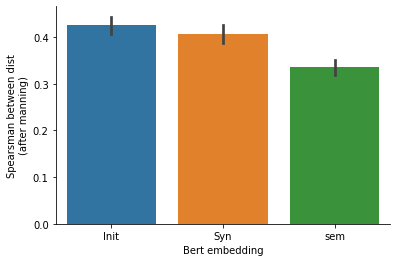

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn", "sem"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between dist\n(after manning)")
sns.despine()

In [162]:
assert len(X_list) == len(Xbar_list) == len(distances) == len(valid)
corr = np.zeros((2, len(X_list))).astype(float)
for i, (X, Xbar, dist) in enumerate(zip(X_list, Xbar_list, distances)):
    corr[0, i] = get_perf(X, dist, manning_proj=True, metric="euclidean")[0]
    corr[1, i] = get_perf(Xbar, dist, manning_proj=True, metric="euclidean")[0]

Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(17, 1024)


(16, 1024)
Constructing TwoWordPSDProbe
(16, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(35, 1024)
Constructing TwoWordPSDProbe
(35, 1024)
Constructing TwoWordPSDProbe
(36, 1024)
Constructing TwoWordPSDProbe
(36, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(29, 1024)
Constructing TwoWordPSDProbe
(29, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(43, 1024)
Constructing TwoWordPSDProbe
(43, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe


/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


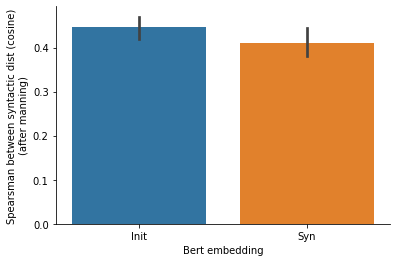

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between syntactic dist (cosine)\n(after manning)")
sns.despine()

In [118]:
assert len(X_list) == len(Xbar_list) == len(distances) == len(valid)
corr = np.zeros((2, len(X_list))).astype(float)
for i, (X, Xbar, dist) in enumerate(zip(X_list, Xbar_list, distances)):
    corr[0, i] = get_perf(X, dist, manning_proj=True, metric="euclidean")[0]
    corr[1, i] = get_perf(Xbar, dist, manning_proj=True, metric="euclidean")[0]

Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(21, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(31, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(28, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(22, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(24, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(19, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(17, 1024)


(34, 1024)
Constructing TwoWordPSDProbe
(34, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(30, 1024)
Constructing TwoWordPSDProbe
(35, 1024)
Constructing TwoWordPSDProbe
(35, 1024)
Constructing TwoWordPSDProbe
(36, 1024)
Constructing TwoWordPSDProbe
(36, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(17, 1024)
Constructing TwoWordPSDProbe
(29, 1024)
Constructing TwoWordPSDProbe
(29, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(13, 1024)
Constructing TwoWordPSDProbe
(43, 1024)
Constructing TwoWordPSDProbe
(43, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(10, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(11, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(12, 1024)
Constructing TwoWordPSDProbe
(18, 1024)
Constructing TwoWordPSDProbe


/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


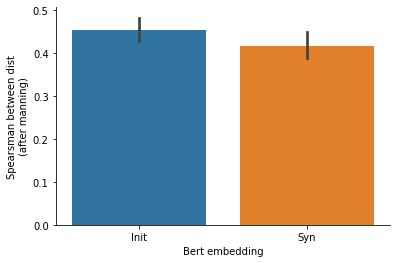

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between dist\n(after manning)")
sns.despine()

/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


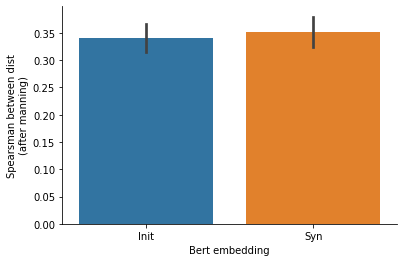

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between dist\n(after manning)")
sns.despine()

/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


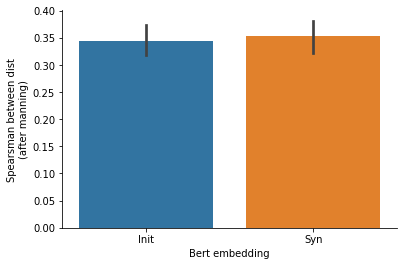

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between dist\n(after manning)")
sns.despine()

/private/home/ccaucheteux/.conda/envs/torch_plot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


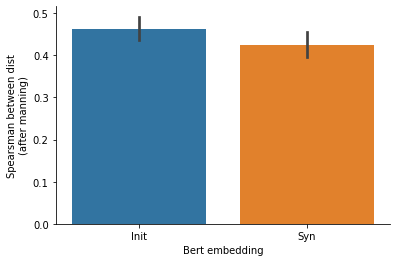

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
res = pd.melt(pd.DataFrame(corr.T))
ax = plt.subplot()
sns.barplot("variable", "value", data = res)
ax.set_xticklabels(["Init", "Syn"])
plt.xlabel("Bert embedding")
plt.ylabel("Spearsman between dist\n(after manning)")
sns.despine()

In [66]:
from sklearn.metrics import pairwise_distances
import pandas as pd
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

def get_corr_syntactic_distance(emb_dir, stimulus, metric="cosine", corr_fun=spearmanr):
    corr = []

    for task, df in stimulus.groupby("task"):

        X = torch.load(emb_dir / task / "sum-gpt2-9.pth")
        Xbar = torch.load(emb_dir / task / "sum-gpt2-9.equiv-random-mean-10.pth")

        for s, group in tqdm(df.groupby("sequ_index")):

            sent = " ".join(group.word.values)
            idx = group.idx.values
            doc = nlp(sent)
            if len(doc) != len(group) or len(doc)<5:
                continue

            triu = np.triu_indices(len(doc))
            true_dist = get_distance_matrix(doc)

            syn_dist = pairwise_distances(Xbar[idx], metric=metric)
            syn_corr = corr_fun(syn_dist[triu], true_dist[triu])

            sem_dist = pairwise_distances(X[idx] - Xbar[idx], metric=metric)
            sem_corr = corr_fun(sem_dist[triu], true_dist[triu])

            init_dist = pairwise_distances(X[idx], metric=metric)
            init_corr = corr_fun(init_dist[triu], true_dist[triu])

            corr.append({"sequ_index": s,
                         "task":task,
                         "sequ_len":len(group),
                         "sem_corr": sem_corr[0],  #correlate(syn_dist[triu], true_dist[triu], False), 
                         "syn_corr": syn_corr[0],  #correlate(sem_dist[triu], true_dist[triu], False), 
                         "init_corr":init_corr[0],
                        #""})
                         "sem_pval": sem_corr[1],  
                         "syn_pval": syn_corr[1],  


                        })
    corr = pd.DataFrame(corr)
    return corr